In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
from collections import Counter

In [2]:
class Config:
    TRAIN_PATH = '../inputs/train.csv'
    TEST_PATH = '../inputs/test.csv'
    TRAIN_LABELS = '../inputs/train_labels.csv'
    SAMPLE_SUBMISSION = '../inputs/sample_submission.csv'

In [4]:
train_df = pd.read_csv(Config.TRAIN_PATH)
train_labels = pd.read_csv(Config.TRAIN_LABELS)

In [5]:
train_labels['question'] = train_labels['session_id'].str.split('q').str[-1].astype('int8')
train_labels['session'] = train_labels['session_id'].str.split('_').str[0]
train_labels.head()

,session_id,correct,question,session
0,20090312431273200_q1,1,1,20090312431273200
1,20090312433251036_q1,0,1,20090312433251036
2,20090314121766812_q1,1,1,20090314121766812
3,20090314363702160_q1,1,1,20090314363702160
4,20090314441803444_q1,1,1,20090314441803444


In [6]:
train_labels['session'] = train_labels['session'].astype('int64')

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

In [267]:
CATS = ['event_name', 'fqid', 'room_fqid', 'text']
NUMS = ['elapsed_time','page','room_coor_x', 'room_coor_y',
        'screen_coor_x', 'screen_coor_y', 'hover_duration']
EVENTS = ['navigate_click','person_click','cutscene_click','object_click',
          'map_hover','notification_click','map_click','observation_click',
          'checkpoint']
ROOMS = ['historicalsociety',
          'kohlcenter',
          'capitol_0',
          'humanecology',
          'drycleaner',
          'library',
          'capitol_1',
          'wildlife',
          'flaghouse',
          'capitol_2']
FQID = ['intro', 'gramps', 'teddy', 'photo', 'notebook',
       'retirement_letter', 'tobasement', 'janitor', 'toentry',
       'groupconvo', 'report', 'boss', 'wells', 'directory',
       'tocollection', 'cs', 'tunic', 'tunic.hub.slip', 'tostacks',
       'outtolunch', 'tocloset', 'tomap', 'tunic.historicalsociety',
       'tunic.kohlcenter', 'plaque', 'plaque.face.date', 'togrampa',
       'tunic.capitol_0', 'chap1_finale', 'chap1_finale_c',
       'tocloset_dirty', 'what_happened', 'trigger_scarf',
       'trigger_coffee', 'tunic.capitol_1', 'tofrontdesk', 'archivist',
       'magnify', 'tunic.humanecology', 'worker', 'businesscards',
       'businesscards.card_0.next', 'businesscards.card_1.next',
       'businesscards.card_bingo.next', 'businesscards.card_bingo.bingo',
       'tohallway', 'tunic.drycleaner', 'logbook', 'logbook.page.bingo',
       'tunic.library', 'tomicrofiche', 'reader', 'reader.paper0.next',
       'reader.paper1.next', 'reader.paper2.bingo', 'wellsbadge',
       'journals', 'journals.hub.topics', 'journals.pic_0.next',
       'journals.pic_1.next', 'journals.pic_2.bingo', 'chap2_finale_c',
       'ch3start', 'seescratches', 'tocage', 'glasses',
       'directory.closeup.archivist', 'key', 'unlockdoor',
       'confrontation', 'savedteddy', 'tocollectionflag',
       'groupconvo_flag', 'tunic.capitol_2', 'tunic.wildlife', 'coffee',
       'crane_ranger', 'remove_cup', 'expert', 'tracks',
       'tracks.hub.deer', 'tunic.flaghouse', 'flag_girl', 'colorbook',
       'reader_flag', 'reader_flag.paper0.next',
       'reader_flag.paper1.next', 'reader_flag.paper2.bingo',
       'archivist_glasses', 'journals_flag',
       'journals_flag.hub.topics_old', 'journals_flag.hub.topics',
       'journals_flag.pic_0.bingo', 'journals_flag.pic_0.next',
       'chap4_finale_c', 'block_tocollection', 'reader.paper2.next',
       'journals.pic_2.next', 'lockeddoor', 'reader.paper2.prev',
       'reader.paper0.prev', 'reader_flag.paper1.prev',
       'journals_flag.pic_0_old.next', 'journals_flag.pic_1_old.next',
       'door_block_clean', 'door_block_talk', 'block',
       'reader_flag.paper2.next', 'journals_flag.pic_1.bingo',
       'journals_flag.pic_1.next', 'journals_flag.pic_2.bingo',
       'journals_flag.pic_2.next', 'reader_flag.paper0.prev',
       'reader.paper1.prev', 'block_magnify',
       'journals_flag.pic_2_old.next', 'block_0', 'doorblock',
       'block_tomap1', 'block_tomap2', 'reader_flag.paper2.prev',
       'need_glasses', 'block_badge', 'block_nelson', 'block_badge_2',
       'block_1', 'fox']

In [9]:
def groupby_apply_elapsed_time(g):
    res = {}
    diff = np.diff(g['elapsed_time'].values)
    res['elapsed_time_diff_mean'] = np.mean(diff)
    res['elapsed_time_diff_std'] = np.std(diff)
    res['elapsed_time_positive'] = len(diff[diff>0])
    res['elapsed_time_negative'] = len(diff) - res['elapsed_time_positive']
    res['start-end'] = g['elapsed_time'].values[-1] - g['elapsed_time'].values[0]
    return pd.Series(res)

In [270]:
def feature_engineer(train):
    dfs = []
    tmp = train.groupby(['session_id','level_group']).apply(groupby_apply_elapsed_time)
    dfs.append(tmp)

    for c in EVENTS:
        train[c] = (train.event_name == c)
    train['main_room'] = train['room_fqid'].str.split('.').str[1]
    for c in ROOMS:
        train[c] = (train.main_room == c)
    for c in FQID:
        train[c] = (train.fqid==c)
    for c1 in ROOMS:
        for c2 in EVENTS:
            train[f'{c1}_{c2}'] = train[c1] & train[c2]
            tmp = train.groupby(['session_id','level_group'])[f'{c1}_{c2}'].sum()
            tmp.name = tmp.name + '_sum'
            dfs.append(tmp)
    for c in EVENTS +ROOMS+ FQID+ ['elapsed_time']:
        tmp = train.groupby(['session_id','level_group'])[c].agg('sum')
        tmp.name = tmp.name + '_sum'
        dfs.append(tmp)
    for c in CATS+FQID:
        tmp = train.groupby(['session_id','level_group'])[c].agg('nunique')
        tmp.name = tmp.name + '_nunique'
        dfs.append(tmp)
    for c in NUMS + EVENTS + ROOMS+FQID:
        tmp = train.groupby(['session_id','level_group'])[c].agg('mean')
        tmp.name = tmp.name + '_mean'
        dfs.append(tmp)
    for c in NUMS+ EVENTS + ROOMS+FQID:
        tmp = train.groupby(['session_id','level_group'])[c].agg('std')
        tmp.name = tmp.name + '_std'
        dfs.append(tmp)
    for c in ['room_coor_x', 'room_coor_y',
        'screen_coor_x', 'screen_coor_y']:
        tmp = train.groupby(['session_id','level_group'])[c].agg('median')
        tmp.name = tmp.name + '_median'
        dfs.append(tmp)
    train.drop(columns=EVENTS+ROOMS,inplace=True)

    df = pd.concat(dfs,axis=1)
    df = df.fillna(-1)
    df = df.reset_index()
    df = df.set_index('session_id')
    return df

In [271]:
%%time
df = feature_engineer(train_df)
print( df.shape )
df.head()

(35337, 684)
CPU times: total: 12min 24s
Wall time: 12min 29s


,level_group,elapsed_time_diff_mean,elapsed_time_diff_std,elapsed_time_positive,elapsed_time_negative,start-end,historicalsociety_navigate_click_sum,historicalsociety_person_click_sum,historicalsociety_cutscene_click_sum,historicalsociety_object_click_sum,...,need_glasses_std,block_badge_std,block_nelson_std,block_badge_2_std,block_1_std,fox_std,room_coor_x_median,room_coor_y_median,screen_coor_x_median,screen_coor_y_median
session_id,,,,,,,,,,,,,,,,,,,,,
20090312431273200,0-4,1188.170732,2447.579017,161.0,3.0,194860.0,58,22,26,8,...,0.0,0.0,0.0,0.0,0.0,0.0,-3.196174,-80.775928,431.0,387.5
20090312431273200,13-22,1040.446301,1985.279111,411.0,8.0,435947.0,107,38,60,6,...,0.0,0.0,0.0,0.0,0.0,0.0,-43.891830,-120.395386,448.5,390.5
20090312431273200,5-12,941.525424,714.119241,291.0,4.0,277750.0,57,56,12,7,...,0.0,0.0,0.0,0.0,0.0,0.0,-16.105584,-86.000000,411.0,402.0
20090312433251036,0-4,1693.855072,3504.819590,136.0,2.0,233752.0,35,18,34,5,...,0.0,0.0,0.0,0.0,0.0,0.0,-86.761832,-95.000000,328.0,405.0
20090312433251036,13-22,2036.150463,10339.121375,1267.0,29.0,2638851.0,251,42,65,36,...,0.0,0.0,0.0,0.0,0.0,0.0,-13.879384,-125.121633,450.0,404.0


In [272]:
from sklearn.model_selection import KFold, GroupKFold
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

In [273]:
FEATURES = [c for c in df.columns if c not in [ 'level_group']]
print('We will train with', len(FEATURES) ,'features')
ALL_USERS = df.index.unique()
print('We will train with', len(ALL_USERS) ,'users info')

We will train with 683 features
We will train with 11779 users info


In [274]:
df[['historicalsociety_object_click_sum',
 'kohlcenter_object_click_sum',
 'capitol_0_object_click_sum',
 'humanecology_object_click_sum',
 'drycleaner_object_click_sum',
 'library_object_click_sum',
 'capitol_1_object_click_sum',
 'wildlife_object_click_sum',
 'flaghouse_object_click_sum',
 'capitol_2_object_click_sum',
 'object_click_sum']]

,historicalsociety_object_click_sum,kohlcenter_object_click_sum,capitol_0_object_click_sum,humanecology_object_click_sum,drycleaner_object_click_sum,library_object_click_sum,capitol_1_object_click_sum,wildlife_object_click_sum,flaghouse_object_click_sum,capitol_2_object_click_sum,object_click_sum
session_id,,,,,,,,,,,
20090312431273200,8,3,0,0,0,0,0,0,0,0,11
20090312431273200,6,0,0,0,0,7,0,3,4,0,20
20090312431273200,7,0,0,7,7,7,0,0,0,0,28
20090312433251036,5,10,0,0,0,0,0,0,0,0,15
20090312433251036,36,2,0,6,11,17,0,4,7,0,83
...,...,...,...,...,...,...,...,...,...,...,...
22100219442786200,6,0,0,0,0,5,0,2,2,0,15
22100219442786200,6,0,0,5,2,10,0,0,0,0,23
22100221145014656,15,12,0,0,0,0,0,0,0,0,27


In [275]:
n_splits=20
gkf = GroupKFold(n_splits=n_splits)
oof = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS)
models = {}

# COMPUTE CV SCORE WITH 5 GROUP K FOLD
for i, (train_index, test_index) in enumerate(gkf.split(X=df, groups=df.index)):
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)

    xgb_params = {
        'objective' : 'binary:logistic',
        'eval_metric':'logloss',
        'learning_rate': 0.01,
        'max_depth': 5,
        'n_estimators': 2000,
        'early_stopping_rounds': 50,
        'tree_method':'hist',
        'subsample':0.8,
        'colsample_bytree': 0.8,
        'min_child_weight':2,
        'alpha':15,
        'lambda':42,
        'tree_method':'gpu_hist',
        'use_label_encoder' : False}

    # ITERATE THRU QUESTIONS 1 THRU 18
    for t in range(1,19):

        # USE THIS TRAIN DATA WITH THESE QUESTIONS
        if t<=3: grp = '0-4'
        elif t<=13: grp = '5-12'
        elif t<=22: grp = '13-22'

        # TRAIN DATA
        train_x = df.iloc[train_index]
        train_x = train_x.loc[train_x.level_group == grp]
        train_users = train_x.index.values
        train_y = train_labels.loc[train_labels.question==t].set_index('session').loc[train_users]

        # VALID DATA
        valid_x = df.iloc[test_index]
        valid_x = valid_x.loc[valid_x.level_group == grp]
        valid_users = valid_x.index.values
        valid_y = train_labels.loc[train_labels.question==t].set_index('session').loc[valid_users]

        # TRAIN MODEL
        clf =  XGBClassifier(**xgb_params)
        clf.fit(train_x[FEATURES].astype('float32'), train_y['correct'],
                eval_set=[(train_x[FEATURES].astype('float32'), train_y['correct']), (valid_x[FEATURES].astype('float32'), valid_y['correct']) ],
                verbose=100)
        print(f'{t}({clf.best_ntree_limit}), ',end='')

        # SAVE MODEL, PREDICT VALID OOF
        models[f'{i}_{grp}_{t}'] = clf
        oof.loc[valid_users, t-1] = clf.predict_proba(valid_x[FEATURES].astype('float32'))[:,1]

    print()



#########################
### Fold 1
#########################
[0]	validation_0-logloss:0.69083	validation_1-logloss:0.69052
[100]	validation_0-logloss:0.57381	validation_1-logloss:0.56452
[200]	validation_0-logloss:0.53898	validation_1-logloss:0.53193
[300]	validation_0-logloss:0.52150	validation_1-logloss:0.51872
[400]	validation_0-logloss:0.50993	validation_1-logloss:0.51249
[500]	validation_0-logloss:0.50078	validation_1-logloss:0.50877
[600]	validation_0-logloss:0.49283	validation_1-logloss:0.50707
[700]	validation_0-logloss:0.48580	validation_1-logloss:0.50598
[800]	validation_0-logloss:0.47959	validation_1-logloss:0.50495
[900]	validation_0-logloss:0.47382	validation_1-logloss:0.50403
[1000]	validation_0-logloss:0.46844	validation_1-logloss:0.50349
[1100]	validation_0-logloss:0.46327	validation_1-logloss:0.50328
[1200]	validation_0-logloss:0.45843	validation_1-logloss:0.50300
[1250]	validation_0-logloss:0.45610	validation_1-logloss:0.50315
1(1202), [0]	validation_0-logloss:0.684

In [280]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df = fi_df.head(50)
    #Define size of bar plot
    plt.figure(figsize=(20,10))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [281]:
feat_imp = {}

In [282]:
for k, v in models.items():
    for x, y in zip(v.feature_importances_, v.feature_names_in_):
        if y not in feat_imp:
            feat_imp[y] = x
        else:
            feat_imp[y]+=x

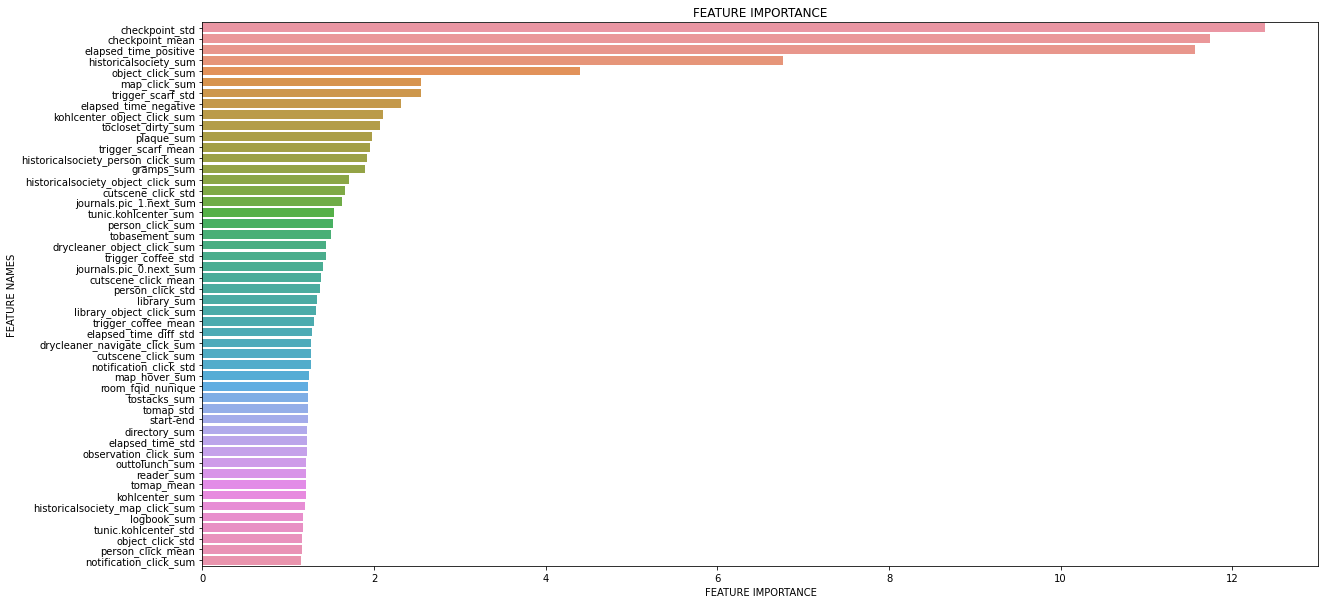

In [283]:
plot_feature_importance(list(feat_imp.values()),list(feat_imp.keys()),'')

In [284]:
# PUT TRUE LABELS INTO DATAFRAME WITH 18 COLUMNS
true = oof.copy()
for k in range(18):
    # GET TRUE LABELS
    tmp = train_labels.loc[train_labels.question == k+1].set_index('session').loc[ALL_USERS]
    true[k] = tmp.correct.values

In [285]:
# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
best_score = 0; best_threshold = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_threshold = threshold

0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 

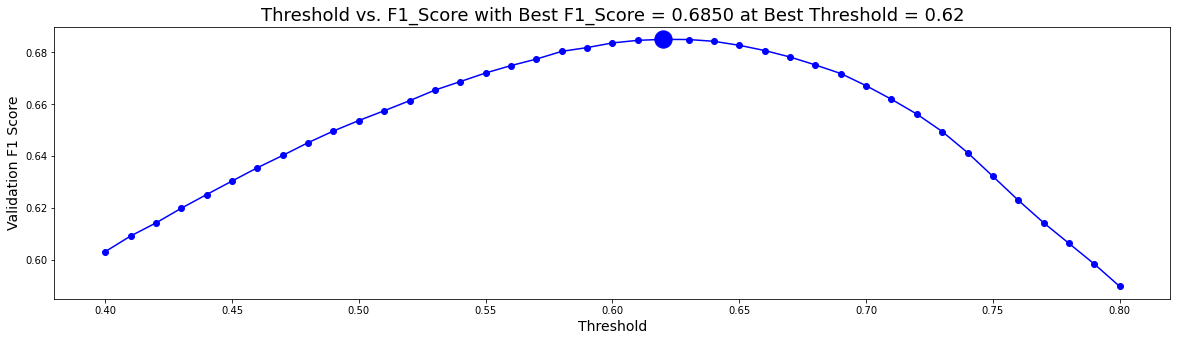

In [286]:
import matplotlib.pyplot as plt

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold], [best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.4f} at Best Threshold = {best_threshold:.3}',size=18)
plt.show()

In [287]:
print('When using optimal threshold...')
for k in range(18):
        
    # COMPUTE F1 SCORE PER QUESTION
    m = f1_score(true[k].values, (oof[k].values>best_threshold).astype('int'), average='macro')
    print(f'Q{k}: F1 =',m)
    
# COMPUTE F1 SCORE OVERALL
m = f1_score(true.values.reshape((-1)), (oof.values.reshape((-1))>best_threshold).astype('int'), average='macro')
print('==> Overall F1 =',m)

When using optimal threshold...
Q0: F1 = 0.6417608870043982
Q1: F1 = 0.4946153516111039
Q2: F1 = 0.4956717840437543
Q3: F1 = 0.6370139371522264
Q4: F1 = 0.6021846841969151
Q5: F1 = 0.6253303771417331
Q6: F1 = 0.6098613501888106
Q7: F1 = 0.5368727704722435
Q8: F1 = 0.6155832478586938
Q9: F1 = 0.5405762918065282
Q10: F1 = 0.5989746277333442
Q11: F1 = 0.5089565170813783
Q12: F1 = 0.4377626254347839
Q13: F1 = 0.6186387539001187
Q14: F1 = 0.5544665300228018
Q15: F1 = 0.4594375205904427
Q16: F1 = 0.5394848358300461
Q17: F1 = 0.49501648917885416
==> Overall F1 = 0.6850458854486219


In [211]:
train_df['room_fqid'].unique()

array(['tunic.historicalsociety.closet',
       'tunic.historicalsociety.basement',
       'tunic.historicalsociety.entry',
       'tunic.historicalsociety.collection',
       'tunic.historicalsociety.stacks', 'tunic.kohlcenter.halloffame',
       'tunic.capitol_0.hall', 'tunic.historicalsociety.closet_dirty',
       'tunic.historicalsociety.frontdesk',
       'tunic.humanecology.frontdesk', 'tunic.drycleaner.frontdesk',
       'tunic.library.frontdesk', 'tunic.library.microfiche',
       'tunic.capitol_1.hall', 'tunic.historicalsociety.cage',
       'tunic.historicalsociety.collection_flag', 'tunic.wildlife.center',
       'tunic.flaghouse.entry', 'tunic.capitol_2.hall'], dtype=object)

In [214]:
import seaborn as sns

<AxesSubplot:xlabel='screen_coor_x', ylabel='screen_coor_y'>

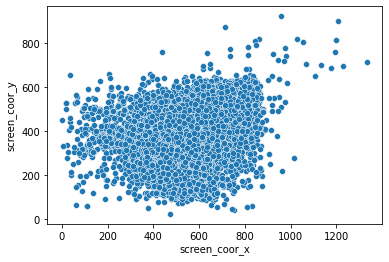

In [240]:
sns.scatterplot(x='screen_coor_x', y='screen_coor_y', data=train_df[(train_df.room_fqid=='tunic.historicalsociety.closet')&(train_df['index']==1)]) 

In [231]:
train_df.groupby('session_id').tail(2)

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,...,flaghouse_checkpoint,capitol_2_navigate_click,capitol_2_person_click,capitol_2_cutscene_click,capitol_2_object_click,capitol_2_map_hover,capitol_2_notification_click,capitol_2_map_click,capitol_2_observation_click,capitol_2_checkpoint
879,20090312431273200,930,1270708,navigate_click,undefined,22,NaN,224.190321,-60.268671,404.0,...,False,True,False,False,False,False,False,False,False,False
880,20090312431273200,931,1272679,checkpoint,basic,22,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,True
2710,20090312433251036,1874,3813349,navigate_click,undefined,22,NaN,239.341836,-17.844428,414.0,...,False,True,False,False,False,False,False,False,False,False
2711,20090312433251036,1875,3815334,checkpoint,basic,22,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,True
3748,20090314121766812,1081,2133005,navigate_click,undefined,22,NaN,270.625777,0.376447,498.0,...,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13171795,22100217104993650,1248,2103885,checkpoint,basic,22,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,True
13172662,22100219442786200,919,1216907,navigate_click,undefined,22,NaN,266.614564,9.428299,432.0,...,False,True,False,False,False,False,False,False,False,False
13172663,22100219442786200,920,1218877,checkpoint,basic,22,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,True
13174209,22100221145014656,1603,5486753,navigate_click,undefined,22,NaN,252.299653,123.805889,526.0,...,False,True,False,False,False,False,False,False,False,False


In [234]:
trai

0        11769
11       11769
1        11769
25       11769
24       11769
         ...  
10437        1
10438        1
10439        1
10440        1
20473        1
Name: index, Length: 20348, dtype: int64